In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [9]:
def generate_sequence(sequence_length, transition_probabilities, num_states, critical_states):
#     init_state = np.random.randint(0, num_states , 1)

    observation_sequence = []
    init_state=3
    current_state = init_state#init state
    state_sequence = np.zeros(sequence_length)
# Generate a single sample from the multivariate normal distribution
    for jj in range(sequence_length):
        current_state = np.random.choice(range(num_states), p=transition_probabilities[current_state])
        mean = [8*current_state, 0]
        cov = [[1, 0], [0, 6]]
        observation = np.random.multivariate_normal(mean, cov)
        observation_sequence.append(observation)
        state_sequence[jj]=current_state
    return np.array(observation_sequence), state_sequence

In [18]:
# Define the number of sequences and the length of each sequence
num_sequences = 1500
sequence_length = 50
#num_states=40

## Define the transition probabilities matrix
#transition_probabilities = 0.026*np.ones((num_states, num_states))


## Define the critical states
# critical_states = np.array([0, 18, 19, 39])
# transition_probabilities[:, critical_states] = 0.016


num_states=10


# Define the transition probabilities matrix
transition_probabilities = 0.115*np.ones((num_states, num_states))


# Define the critical states
critical_states = np.array([0, 9])
transition_probabilities[:, critical_states] = 0.04



# transition_probabilities /= np.sum(transition_probabilities, axis=1, keepdims=True)

# Generate the dataset of sequences
dataset = []
outcomes = []
state_seqs_list = []
np.random.seed(41)
for _ in range(num_sequences):
    sequence,  state_sequence = generate_sequence(sequence_length, 
                                                                           transition_probabilities, 
                                                                           num_states,
                                                                           critical_states)
    
    dataset.append(sequence)
    
    # Determine the outcome based on the number of transitions to critical states
    critical_transition_inds = np.isin(state_sequence, critical_states)
    thr_1 = 1#1
    thr_2 = 2.5#2
    thr_3 = 5#3
    
    high_val_inds = np.logical_or(sequence[:, 1] < -thr_3, sequence[:, 1] > thr_3)
    high_mid_val_inds = np.logical_or(
        np.logical_and(sequence[:, 1] < -thr_2, sequence[:, 1] > -thr_3),
        np.logical_and(sequence[:, 1] < thr_3, sequence[:, 1] > thr_2)
    )
    low_mid_val_inds = np.logical_or(
        np.logical_and(sequence[:, 1] < -thr_1, sequence[:, 1] > -thr_2),
        np.logical_and(sequence[:, 1] < thr_2, sequence[:, 1] > thr_1)
    )
    
    
    
    if np.sum(np.logical_and(critical_transition_inds, high_val_inds)) >= 1:
        outcome = 3
    elif np.sum(np.logical_and(critical_transition_inds, high_mid_val_inds)) >= 2:
        outcome = 2
    elif np.sum(np.logical_and(critical_transition_inds, low_mid_val_inds)) >= 2:
        outcome = 1
    else:
        outcome = 0
    
    outcomes.append(outcome)
    state_seqs_list.append(state_sequence)

# Convert the dataset and outcomes to arrays
dataset = np.array(dataset)
outcomes = np.array(outcomes)

# Print the shape of the dataset and outcomes
print("Dataset shape:", dataset.shape)
print("Outcomes shape:", outcomes.shape)

for y in np.unique(outcomes):
    print('Number of outcome %d sequences : %d'%(y, np.sum(outcomes==y)))


Dataset shape: (1500, 50, 2)
Outcomes shape: (1500,)
Number of outcome 0 sequences : 483
Number of outcome 1 sequences : 417
Number of outcome 2 sequences : 353
Number of outcome 3 sequences : 247


## Visualize sequences as 2d scatter plots

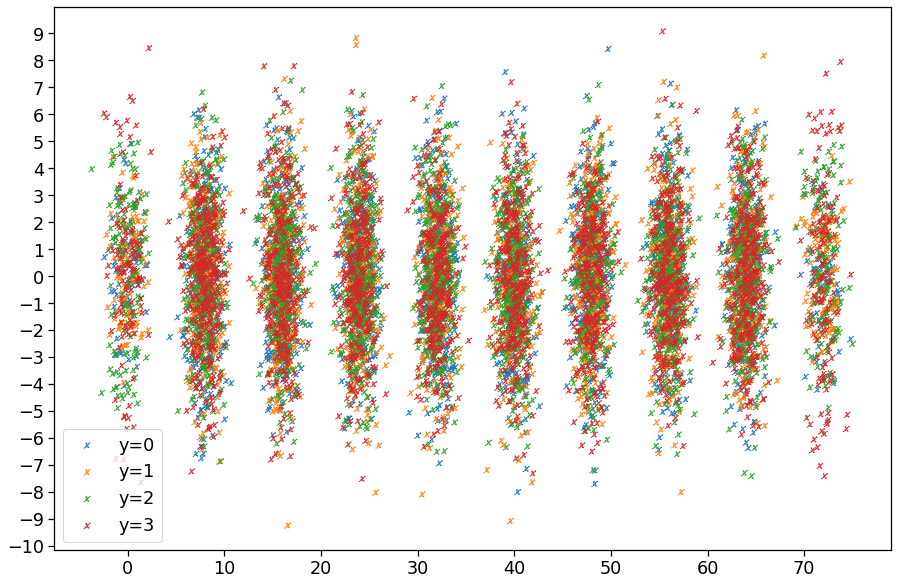

In [19]:
f, axs = plt.subplots(1, 1, figsize=(15, 10))
sns.set_context("notebook", font_scale=1.6)


for jj, ordinal_label in enumerate(np.unique(outcomes)):
    feature_vals_ND_labels_y = dataset[outcomes==ordinal_label][:50]

    # plot time series sequence of example with label 0 and 1
    axs.scatter(feature_vals_ND_labels_y[:, :, 0], feature_vals_ND_labels_y[:, :, 1],
                marker='$x$', linestyle=':',  label=f'y={ordinal_label}')
    
#     axs.set_title('10 sequences with label y=%d'%ordinal_label)
    axs.set_yticks(np.arange(-10, 10))
    axs.legend()

plt.show()

## Visualize sequences as time series

<Figure size 720x432 with 0 Axes>

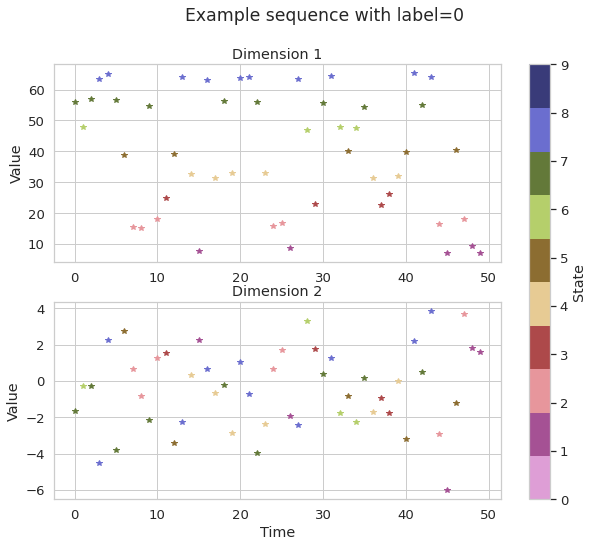

<Figure size 720x432 with 0 Axes>

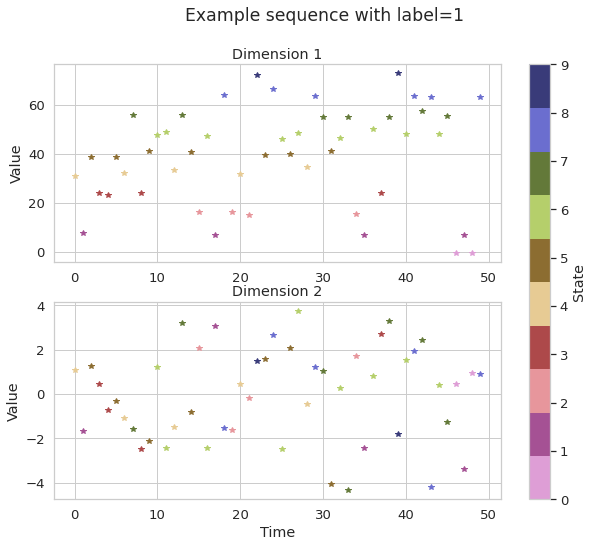

<Figure size 720x432 with 0 Axes>

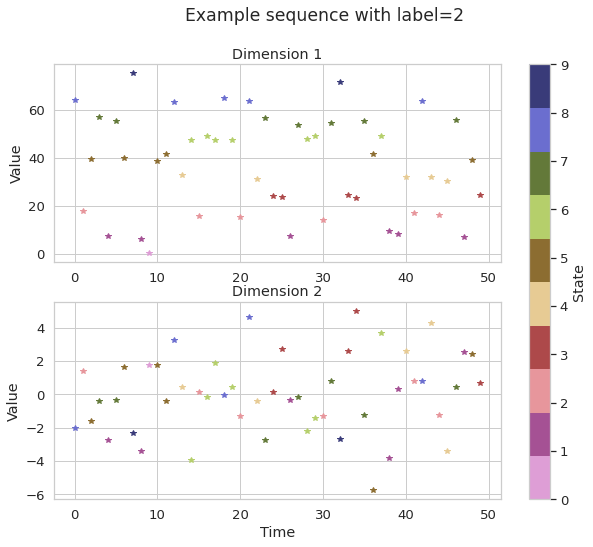

<Figure size 720x432 with 0 Axes>

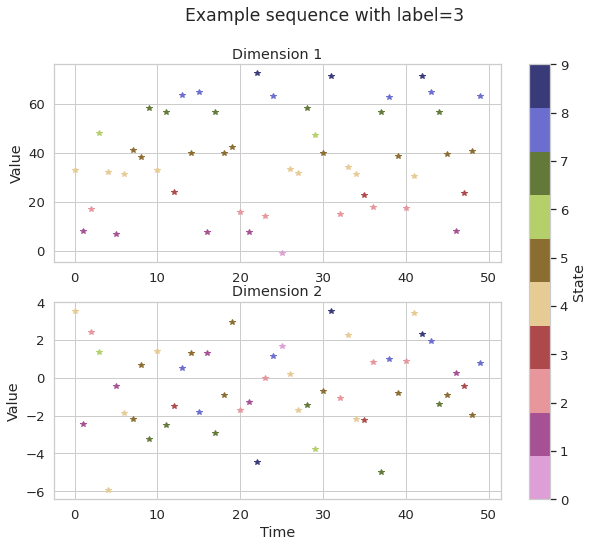

In [5]:
for label in np.unique(outcomes):
    
    # Plot the sequence with state overlay
    cmap = plt.get_cmap("tab20b_r", num_states)
    plt.figure(figsize=(10, 6))
    
    
    # get indexes of sequences with the the required label
    label_inds = np.flatnonzero(outcomes==label)
    
    # plot a single sequence with state overlay
    seq_id=label_inds[1]
    state_sequence = state_seqs_list[seq_id]
    observation_sequence = dataset[seq_id]

    # Create subplots for each dimension
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    sns.set_context('notebook', font_scale=1.2)
    sns.set_style('whitegrid')

    # Plot each dimension separately
    for i in range(2):
        axs[i].set_title(f"Dimension {i+1}")
        axs[i].set_ylabel("Value")

        # plot sequence with state overlay
        for j in range(num_states):
            idx = np.where(state_sequence == j)
            color = cmap(j / (num_states - 1))  # Normalize state value between 0 and 1
            axs[i].plot(idx[0], np.squeeze(observation_sequence[idx, i]), marker='*', linestyle='None',
                        color=color, alpha=1)

    # Create a single colorbar for both axes
    norm = plt.Normalize(0, num_states - 1)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), ticks=range(num_states))
    cbar.set_label('State')

    # Set x-axis label and ticks on the bottom subplot
    axs[-1].set_xlabel("Time")
    
    fig.suptitle('Example sequence with label=%d'%label)
    # plt.tight_layout()

# Show the plot
plt.show()

# Save the dataset as train/valid/test 

In [7]:
from sklearn.model_selection import train_test_split


# Set the random seed for reproducibility
random_seed = 42

# Split the dataset into train/validation and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(dataset, outcomes, test_size=0.2, 
                                                            random_state=random_seed)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=random_seed)


# Print the sizes of the resulting sets
print("Train set size:", len(y_train))
print("Validation set size:", len(y_val))
print("Test set size:", len(y_test))


save_dir = '/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/data/toydata_many_states'
for split, x, y in [('train', x_train, y_train),
                ('valid', x_val, y_val),
                ('test', x_test, y_test)]:
    for label in np.unique(outcomes):
        print('Number of outcome %d sequences in %s: %d'%(label, split, np.sum(y==label)))
        
print('Saving data to %s'%save_dir)
np.save(os.path.join(save_dir, 'X_train.npy'), x_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
print('Done saving train..')
np.save(os.path.join(save_dir, 'X_valid.npy'), x_val)
np.save(os.path.join(save_dir, 'y_valid.npy'), y_val)
print('Done saving valid..')
np.save(os.path.join(save_dir, 'X_test.npy'), x_test)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)
print('Done saving test..')


Train set size: 960
Validation set size: 240
Test set size: 300
Number of outcome 0 sequences in train: 441
Number of outcome 1 sequences in train: 233
Number of outcome 2 sequences in train: 145
Number of outcome 3 sequences in train: 141
Number of outcome 0 sequences in valid: 123
Number of outcome 1 sequences in valid: 44
Number of outcome 2 sequences in valid: 36
Number of outcome 3 sequences in valid: 37
Number of outcome 0 sequences in test: 123
Number of outcome 1 sequences in test: 63
Number of outcome 2 sequences in test: 48
Number of outcome 3 sequences in test: 66
Saving data to /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/data/toydata_many_states
Done saving train..
Done saving valid..
Done saving test..


In [26]:
seq = dataset[outcomes==1][1]
seq[np.argsort(seq[:, 0])]

array([[-2.19,  5.38],
       [-0.22,  1.51],
       [ 0.25,  0.34],
       [ 0.37, -1.7 ],
       [ 0.54, -1.61],
       [ 0.84, -0.12],
       [ 7.37,  2.55],
       [ 7.72, -3.83],
       [ 7.73,  2.65],
       [ 7.8 ,  3.37],
       [ 8.37, -3.05],
       [ 9.93,  0.09],
       [10.06,  4.69],
       [15.1 ,  0.79],
       [16.35,  0.05],
       [16.58,  5.77],
       [16.61,  5.  ],
       [18.16,  0.23],
       [23.02, -0.13],
       [23.93,  4.38],
       [25.56,  1.71],
       [30.12, -1.14],
       [31.1 ,  4.44],
       [31.88,  0.65],
       [32.12, -1.67],
       [32.34, -2.42],
       [32.57, -4.85],
       [33.6 , -2.57],
       [39.03, -3.19],
       [39.07,  2.43],
       [39.91,  0.36],
       [40.34, -1.4 ],
       [40.39, -0.99],
       [41.38, -0.3 ],
       [41.53,  0.14],
       [45.86,  0.25],
       [46.62, -3.2 ],
       [47.4 ,  0.24],
       [48.74,  0.54],
       [49.76,  1.43],
       [54.75,  1.99],
       [55.54,  0.98],
       [55.89,  2.86],
       [57.

In [21]:
np.set_printoptions(suppress=True, precision=2)